In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

# Chargement
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

# --- CRÉATION DE DIMENSIONS CRÉATIVES ---
df_creative = pd.DataFrame()

# 1. Équilibre (Work-Life Balance)
df_creative['Equilibre_Sain'] = df['WorkLifeBalance'].apply(lambda x: True if x >= 3 else False)
df_creative['Pas_Heures_Sup'] = df['OverTime'].apply(lambda x: True if x == 'No' else False)

# 2. Climat Social (Environment & Relationship)
df_creative['Bon_Environnement'] = df['EnvironmentSatisfaction'].apply(lambda x: True if x >= 3 else False)
df_creative['Bonnes_Relations'] = df['RelationshipSatisfaction'].apply(lambda x: True if x >= 3 else False)

# 3. Épanouissement (Involvement & Job Satisfaction)
df_creative['Tres_Engagé'] = df['JobInvolvement'].apply(lambda x: True if x >= 3 else False)
df_creative['HAUTE_SATISFACTION'] = df['JobSatisfaction'].apply(lambda x: True if x >= 4 else False)

# 4. Contexte de Carrière
df_creative['Niveau_Expert'] = df['JobLevel'].apply(lambda x: True if x >= 3 else False)
df_creative['Dep_' + df['Department']] = True # Encodage auto des départements

# On remplit les NaNs par False (cas des départements)
df_creative = df_creative.fillna(False)

print("Dimensions créatives créées. Analyse des 'Micro-Climats' en cours...")

Dimensions créatives créées. Analyse des 'Micro-Climats' en cours...


In [8]:
# 1. Application d'Apriori avec un support plus bas (0.02 au lieu de 0.05) pour être plus sensible
frequent_itemsets = apriori(df_creative, min_support=0.02, use_colnames=True)

# 2. Génération des règles
# Si aucune règle n'est trouvée avec lift=1.1, on baisse à 1.0
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# 3. Vérification si des règles existent
if not rules.empty:
    # Filtrer pour le but ultime : La Haute Satisfaction
    # On utilise .str.contains pour plus de robustesse sur les types "frozenset"
    satisfaction_rules = rules[rules['consequents'].apply(lambda x: 'HAUTE_SATISFACTION' in x)]
    
    if not satisfaction_rules.empty:
        # Trier par confiance
        satisfaction_rules = satisfaction_rules.sort_values(by='confidence', ascending=False)
        print(f"✅ {len(satisfaction_rules)} chemins vers le bonheur trouvés.")
    else:
        print("⚠️ Aucune règle spécifique menant à 'HAUTE_SATISFACTION' n'a été trouvée.")
        satisfaction_rules = pd.DataFrame() # Créer un DF vide pour éviter les erreurs plus loin
else:
    print("❌ Aucune règle d'association trouvée. Essayez de baisser 'min_support' dans apriori().")
    satisfaction_rules = pd.DataFrame()

✅ 3550 chemins vers le bonheur trouvés.


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)


C:\Users\DELL\AppData\Local\Temp\ipykernel_32460\2151606417.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='antecedents_str', data=top_rules, palette='viridis')
C:\Users\DELL\AppData\Local\Temp\ipykernel_32460\2151606417.py:19: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


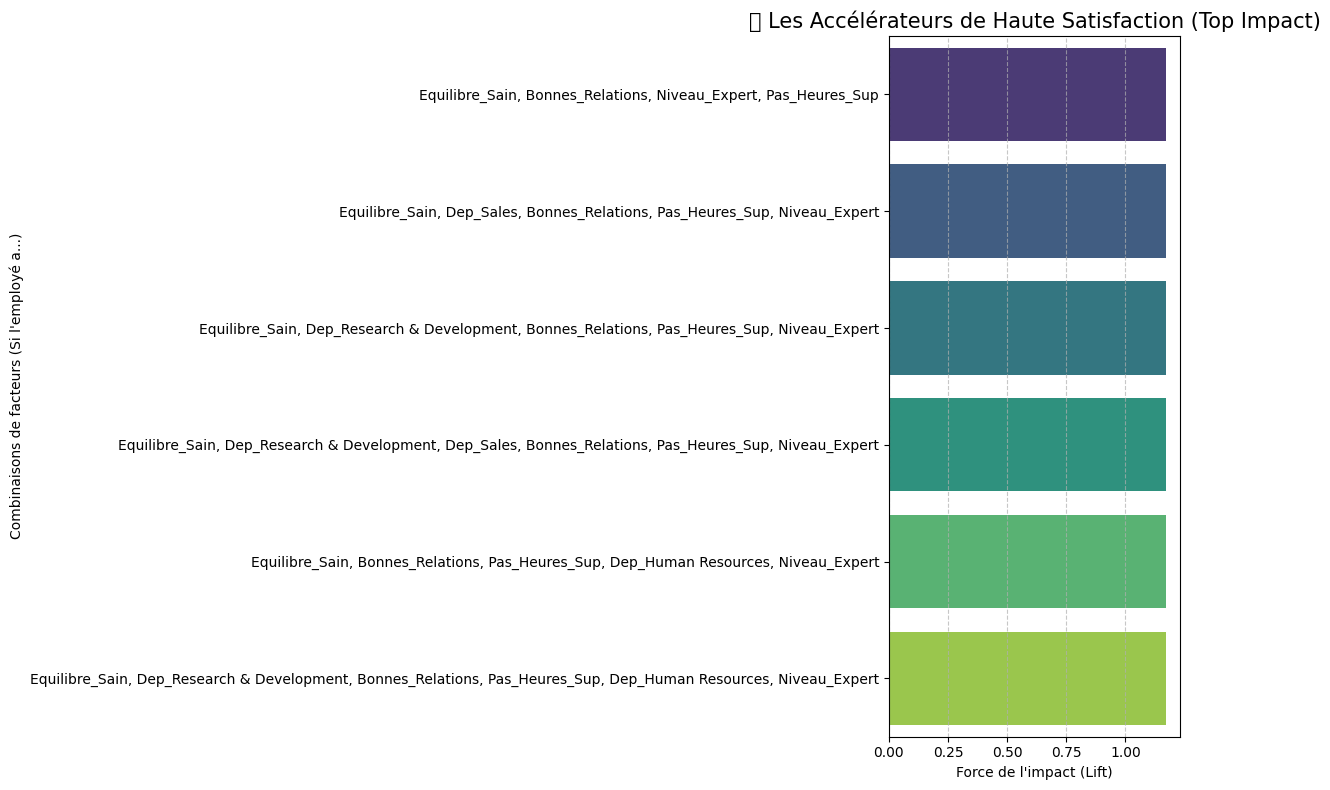

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

if not satisfaction_rules.empty:
    # On prend les 10 meilleures règles pour la visualisation
    top_rules = satisfaction_rules.head(10).copy()
    
    # Transformation des antécédents en texte lisible pour l'axe Y
    top_rules['antecedents_str'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))

    plt.figure(figsize=(12, 8))
    # Utilisation d'une palette de couleurs dégradée
    sns.barplot(x='lift', y='antecedents_str', data=top_rules, palette='viridis')
    
    plt.title('🚀 Les Accélérateurs de Haute Satisfaction (Top Impact)', fontsize=15)
    plt.xlabel('Force de l\'impact (Lift)')
    plt.ylabel('Combinaisons de facteurs (Si l\'employé a...)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Graphique impossible : le jeu de règles est vide.")

🏆 PODIUM DES FACTEURS DE SATISFACTION
Ce classement montre quels facteurs reviennent le plus souvent dans les profils d'employés heureux.
------------------------------------------------------------


,Facteur_RH,Nombre_de_Regles_Gagnantes
1,Bonnes_Relations,432
2,Niveau_Expert,432
3,Pas_Heures_Sup,243
4,Dep_Sales,225
6,Dep_Human Resources,225
5,Dep_Research & Development,225
0,Equilibre_Sain,216
7,Tres_Engagé,27


C:\Users\DELL\AppData\Local\Temp\ipykernel_32460\2911815731.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Nombre_de_Regles_Gagnantes', y='Facteur_RH', data=df_ranking, palette='coolwarm')
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


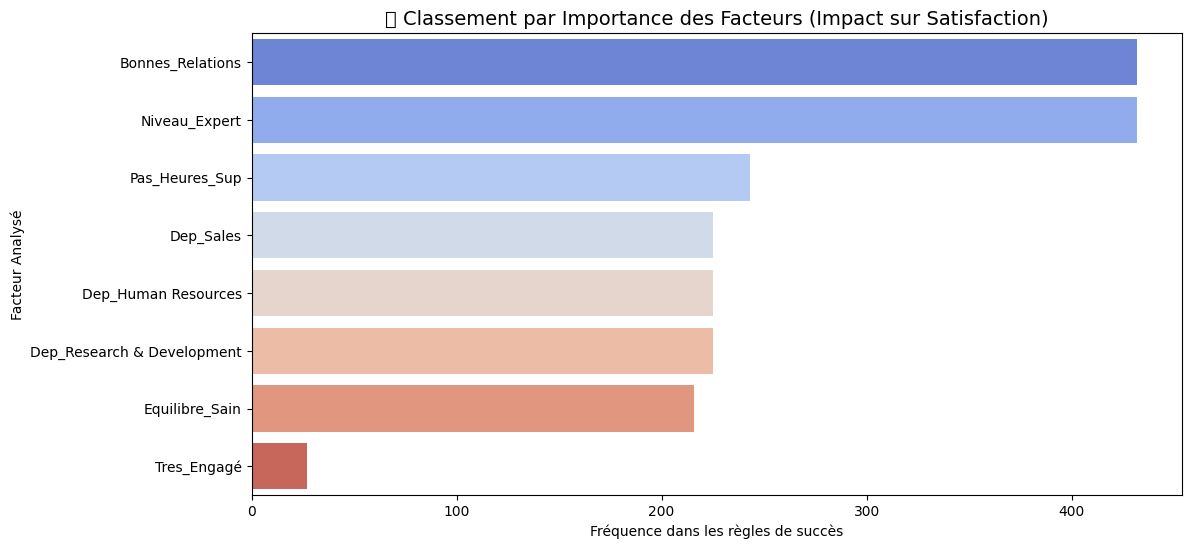

In [10]:
from collections import Counter

# 1. Sélectionner les règles avec un impact réel (Lift > 1.1)
# On se concentre sur les chemins qui mènent à la HAUTE_SATISFACTION
rules_for_ranking = satisfaction_rules[satisfaction_rules['lift'] > 1.1]

# 2. Extraire tous les facteurs individuels des antécédents
all_factors = []
for itemset in rules_for_ranking['antecedents']:
    all_factors.extend(list(itemset))

# 3. Compter la fréquence d'apparition de chaque facteur
importance_counts = Counter(all_factors)

# 4. Transformer en DataFrame pour un affichage propre
df_ranking = pd.DataFrame(importance_counts.items(), columns=['Facteur_RH', 'Nombre_de_Regles_Gagnantes'])
df_ranking = df_ranking.sort_values(by='Nombre_de_Regles_Gagnantes', ascending=False)

# 5. Affichage du Classement
print("🏆 PODIUM DES FACTEURS DE SATISFACTION")
print("Ce classement montre quels facteurs reviennent le plus souvent dans les profils d'employés heureux.")
print("-" * 60)
display(df_ranking.style.background_gradient(cmap='Greens'))

# 6. Visualisation Graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='Nombre_de_Regles_Gagnantes', y='Facteur_RH', data=df_ranking, palette='coolwarm')
plt.title('📊 Classement par Importance des Facteurs (Impact sur Satisfaction)', fontsize=14)
plt.xlabel('Fréquence dans les règles de succès')
plt.ylabel('Facteur Analysé')
plt.show()